# Introduction
Customer review is a crucial information for company to understand their customers feedback for the products and services. So that the company could adjust its strategies to better serve their customers. However, before reading the huge text, it would be great if we can get an overview of topics and the summarized opinion before dive into the details.
The purpose of this project is to use semantic analysis (NLTK, genism), unsupervised topic model (LDA), and abstractive text summarization methods(T5) to better understand customer review. The methods will be used for my future work in an ML company that helps retailers improve their online shopping revenue and customer perception. I use this public data (Amazon food review) from Kaggle for this project to prevent the company's data leakage. The data can be found on: [Kaggle](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews).

# Content:


1.   Data Preprocessing
2.   Review summary & text overview
3.   Topic modeling 
4.   Text summarization by topics
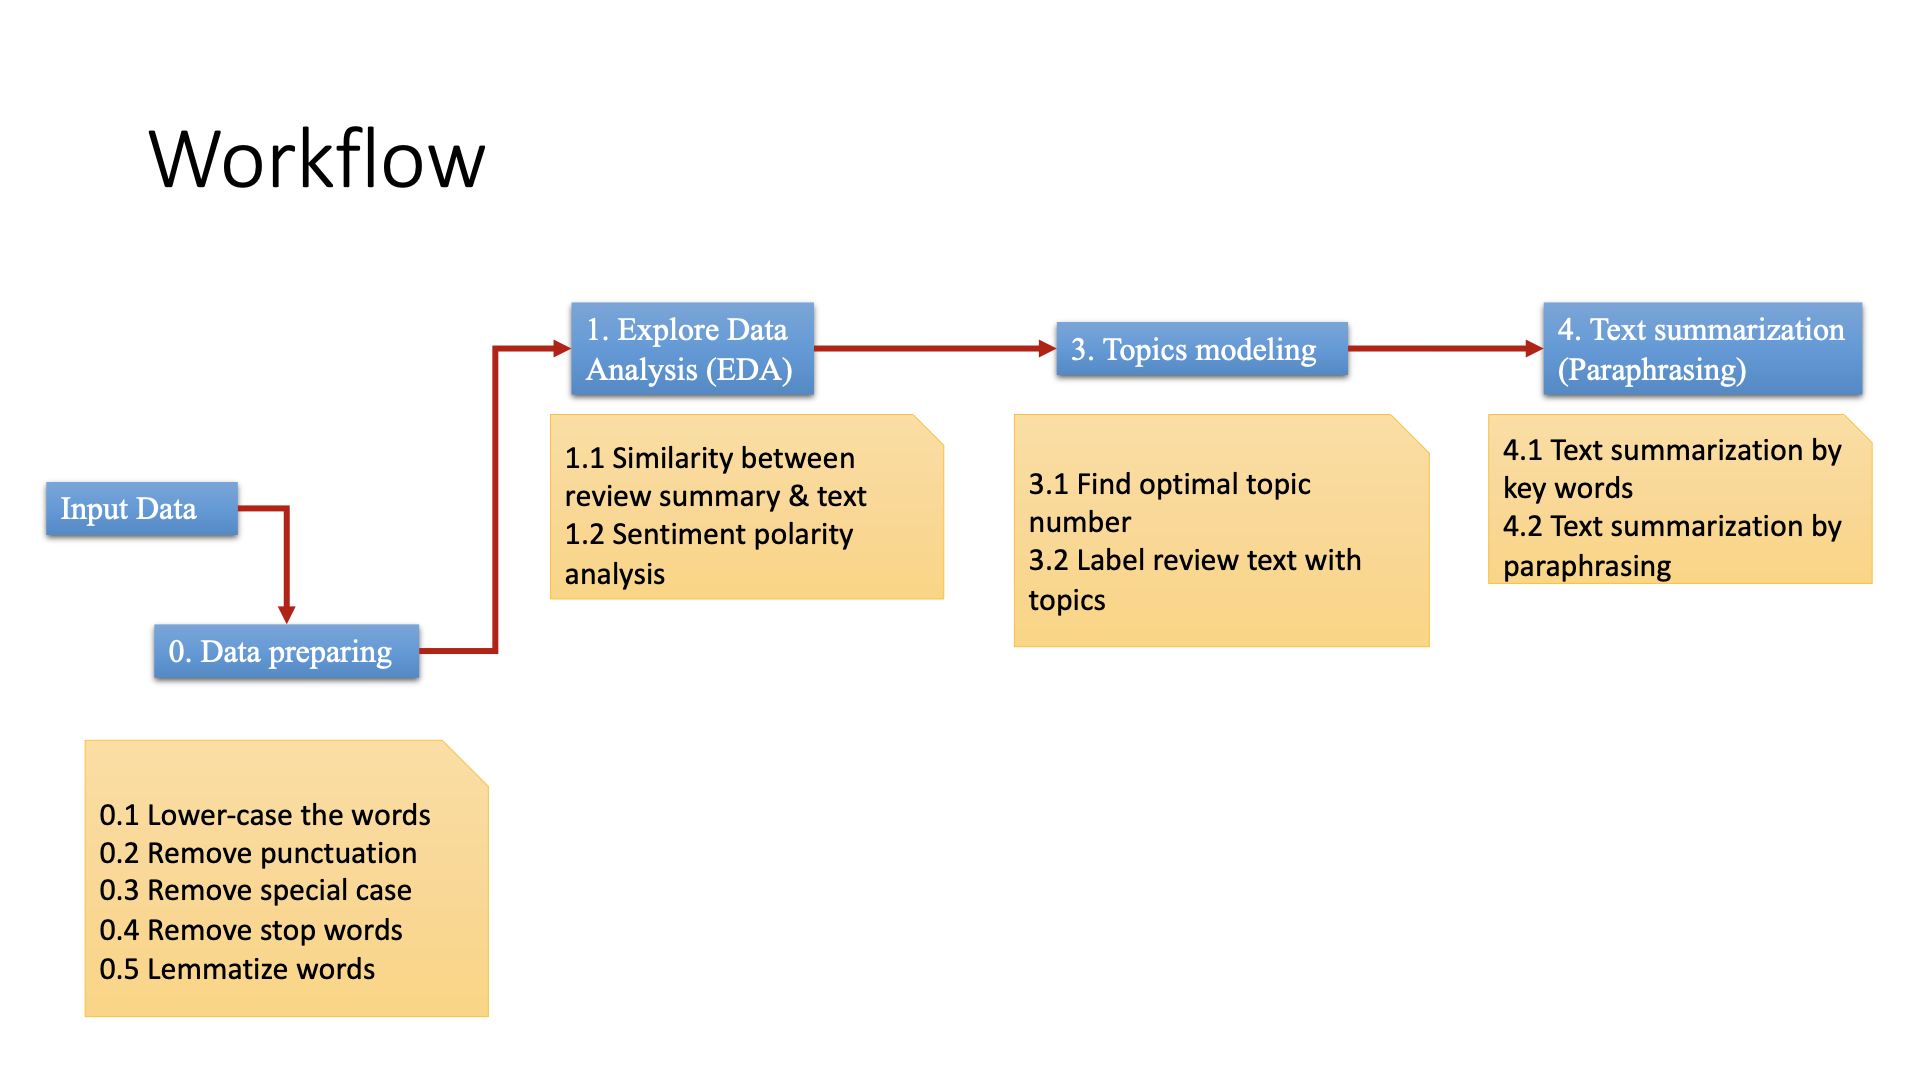


## 1. Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Load the regular expression library
import re
# Import the wordcloud library
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

In [ ]:
amazon = pd.read_csv('/content/drive/MyDrive/447 NLP/Final Project/amazon_reviews.csv')

In [ ]:
from nltk.stem import WordNetLemmatizer
import nltk
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download("stopwords")
stop_words = stopwords.words('english')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")

lemmatizer = WordNetLemmatizer()

##Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(wordnet.ADV)
    else:          
        return(None)

##Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet
def lemmatize_tweet(tweet):
    #tokenize the tweet and find the POS tag for each token
    tweet = tweet_cleaner(tweet) #tweet_cleaner() will be the function you will write
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_tweet))


def tweet_cleaner(x):
  # lower case
  x = x.lower()
  # remove stop words
  x = ' '.join([word for word in x.split(' ') if word not in stop_words])
  # remove emoji
  x = x.encode(encoding="ascii", errors="ignore").decode()
  # remove hashtags
  x = re.sub("#\S+", " ", x)
  # remove mentions
  x = re.sub("@\S+", " ", x)
  # remove URL/links
  x = re.sub("https*\S+", " ", x)
  #remove punctuation
  x = re.sub('[%s]' % re.escape(string.punctuation), ' ', x)
  # remove overspaces
  x = re.sub('\s{2,}', " ", x)
  # remove ticks
  x = re.sub("\'\w+", '', x)
  # remove words shorter than 3
  x = re.sub(r'\b\w{1,2}\b', '', x)
  # decontracred phrase
  
  
  return x

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# compute clean data for text
amazon['Text_clean'] = amazon.Text.apply(lemmatize_tweet)
# compute clean data for summary
amazon['Summary_clean'] = amazon.Summary.astype(str).apply(lemmatize_tweet)
# combine Summary + Text as Review_clean for text mining
amazon['Review_clean']= amazon['Summary_clean'] + ' '+ amazon['Text_clean']

## 2. Review Summary & Text overview
*   Similarity between review summary & Text
*   Text Sentiment polarity analysis





###1.2 Similarity between Summary & Text
Whether or not review summary is enough to represent customer point of view without review text?


In [ ]:
import math
import re
from collections import Counter

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

In [ ]:
amazon['Summary_vec'] = amazon.Summary_clean.astype(str).apply(text_to_vector)
amazon['Text_vec'] = amazon.Text_clean.apply(text_to_vector)

In [ ]:
amazon['Cosine_sim'] = list(map(get_cosine, amazon['Summary_vec'], amazon['Text_vec']))
sns.kdeplot(amazon['Cosine_sim'])

The similarity value between text and summary are not very high. The majority of the score stays below 0.6. In fact, the density is at its highest when cosine similarity is 0. The density hit to 9 when the cosine similarity ranges between -0.05 to 0.03. When cosine similarity is between 0.04 to 0.6, the density stays below 2. As the conclusion, summary does not predictive text, only very few summaries describe what the text says. **Thus, we need to analyze the review summary and text together**.

###2.2 Text Sentiment polarity analysis

In [ ]:
# add sentiment anaylsis columns
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
amazon["sentiments"] = amazon["Review_clean"].apply(lambda x: sid.polarity_scores(x))
amazon = pd.concat([amazon.drop(['sentiments'], axis=1), amazon['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(amazon["Score"].values.reshape(1, -1), amazon["compound"].values.reshape(1, -1))

The similarity between Score and Sentiments compound score is 0.92 which means that text sentiment score can represent customer review score.

In [ ]:
# Save df into parquet format to save time of loading
amazon.to_parquet('amazon_reviews.parquet.gzip', compression="gzip")
!cp amazon_reviews.parquet.gzip "/content/drive/MyDrive/447 NLP/Final Project/"

## 3. Extract topics

### 3.1 Find the optimal topic number

Import the partquet format of dataset to save time. If there is no interruption, this step can be skipped

In [ ]:
%%time
amazon = pd.read_parquet("/content/drive/MyDrive/447 NLP/Final Project/amazon_reviews.parquet.gzip")

CPU times: user 6.36 s, sys: 1.71 s, total: 8.08 s
Wall time: 10.7 s


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
docs = list(amazon['Review_clean'])
vec = CountVectorizer(lowercase = True, stop_words = stop_words,ngram_range = (1,3),max_features = 5000)
X = vec.fit_transform(docs)

In [ ]:
#convert our scipy_sparse_matrix 'X' into genism corpus using matutils
from gensim import matutils,models
corpus = matutils.Sparse2Corpus(X.T)
#id2word is a dictionary containing all terms(mapped to a code) and their locations(indexes) in term-document matrix
id2word = dict([(k,v) for k,v in enumerate(vec.get_feature_names())])


In [ ]:
# save our corpus in "mm" format as it can be processed faster
from gensim import corpora
corpora.MmCorpus.serialize('all_text_corpus.mm',corpus)

In [ ]:
corpusmm = corpora.MmCorpus('all_text_corpus.mm')

In [ ]:
#LdA with 5 topics
lda = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 5,passes=2,eval_every = None)
lda.print_topics()

[(0,
  '0.048*"coffee" + 0.042*"tea" + 0.025*"cup" + 0.019*"flavor" + 0.017*"taste" + 0.014*"like" + 0.013*"good" + 0.012*"drink" + 0.009*"try" + 0.009*"one"'),
 (1,
  '0.031*"food" + 0.029*"dog" + 0.019*"treat" + 0.017*"love" + 0.014*"cat" + 0.010*"get" + 0.010*"eat" + 0.010*"like" + 0.010*"one" + 0.007*"give"'),
 (2,
  '0.016*"like" + 0.015*"use" + 0.014*"taste" + 0.011*"make" + 0.011*"good" + 0.009*"flavor" + 0.008*"get" + 0.008*"product" + 0.008*"one" + 0.008*"water"'),
 (3,
  '0.022*"taste" + 0.016*"like" + 0.015*"good" + 0.013*"flavor" + 0.013*"great" + 0.012*"love" + 0.011*"chocolate" + 0.010*"sugar" + 0.010*"chip" + 0.009*"snack"'),
 (4,
  '0.021*"price" + 0.021*"product" + 0.021*"amazon" + 0.020*"great" + 0.019*"order" + 0.018*"buy" + 0.016*"find" + 0.015*"store" + 0.012*"get" + 0.012*"love"')]

In [ ]:
#LdA with 5 topics
lda = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 5,passes=2,eval_every = None)
lda.print_topics()

[(0,
  '0.027*"taste" + 0.020*"like" + 0.017*"flavor" + 0.015*"good" + 0.011*"chocolate" + 0.010*"sugar" + 0.009*"great" + 0.009*"sweet" + 0.008*"one" + 0.008*"snack"'),
 (1,
  '0.017*"product" + 0.016*"amazon" + 0.016*"price" + 0.016*"buy" + 0.016*"order" + 0.014*"great" + 0.013*"get" + 0.012*"find" + 0.012*"bag" + 0.012*"store"'),
 (2,
  '0.029*"food" + 0.026*"dog" + 0.018*"treat" + 0.015*"love" + 0.013*"cat" + 0.011*"get" + 0.010*"like" + 0.009*"one" + 0.009*"eat" + 0.007*"give"'),
 (3,
  '0.020*"use" + 0.015*"make" + 0.011*"like" + 0.011*"good" + 0.011*"great" + 0.010*"taste" + 0.010*"product" + 0.010*"oil" + 0.008*"salt" + 0.008*"add"'),
 (4,
  '0.046*"coffee" + 0.040*"tea" + 0.024*"cup" + 0.017*"flavor" + 0.016*"taste" + 0.014*"like" + 0.013*"good" + 0.009*"try" + 0.009*"one" + 0.009*"great"')]

In [ ]:
# remove some words from above observation:
domain2 = ["store","find","amazon","order","item","arrive","receive","package","open","pack","packet","box","food","review",
           "eat","well","recommend","highly","help","purchase","money","price","cost","free","pay","payment","list","feel",
          "subscribe","thing","sell","top","recommendation"]
stop_words.extend(domain2)

Find the optimal topic number

In [ ]:
docs = list(amazon['Review_clean'])
vec = CountVectorizer(lowercase = True, stop_words = stop_words,ngram_range = (1,3),max_features = 5000)
X = vec.fit_transform(docs)
corpus = matutils.Sparse2Corpus(X.T)
id2word = dict([(k,v) for k,v in enumerate(vec.get_feature_names())])

In [ ]:
# find the optimal topic number
from gensim.models.coherencemodel import CoherenceModel
c_score = []
for topic in range(5,25,5):
    lda_model = models.LdaMulticore(corpus = corpusmm,id2word = id2word, num_topics = topic,eval_every = None,passes=2)
    umass_metric = CoherenceModel(model = lda_model,corpus = corpus,coherence = "u_mass")
    c_score.append(umass_metric.get_coherence())

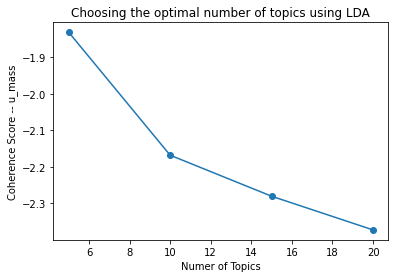

In [ ]:
#umass-graph
topics = range(5,25,5)
plt.figure()
plt.plot(topics,c_score,marker = "o")
plt.xlabel("Numer of Topics")
plt.ylabel("Coherence Score -- u_mass")
plt.title("Choosing the optimal number of topics using LDA") 
plt.show()

From the above curve we can see that topic number = 15 is optimal.

In [ ]:
#LdA with 5 topics
lda5 = models.LdaMulticore(corpus = corpusmm, id2word = id2word,num_topics = 5, passes=3,eval_every = None)

In [ ]:
lda5.show_topics()

[(0,
  '0.021*"use" + 0.014*"make" + 0.013*"like" + 0.012*"taste" + 0.011*"good" + 0.010*"product" + 0.010*"water" + 0.008*"great" + 0.008*"add" + 0.008*"oil"'),
 (1,
  '0.024*"taste" + 0.018*"like" + 0.015*"good" + 0.015*"flavor" + 0.011*"great" + 0.011*"chip" + 0.010*"love" + 0.010*"chocolate" + 0.010*"sugar" + 0.009*"eat"'),
 (2,
  '0.030*"food" + 0.028*"dog" + 0.019*"treat" + 0.018*"love" + 0.014*"cat" + 0.011*"get" + 0.010*"like" + 0.010*"eat" + 0.010*"one" + 0.007*"give"'),
 (3,
  '0.019*"product" + 0.018*"price" + 0.018*"amazon" + 0.017*"buy" + 0.017*"order" + 0.015*"great" + 0.013*"store" + 0.013*"find" + 0.013*"get" + 0.011*"good"'),
 (4,
  '0.043*"coffee" + 0.038*"tea" + 0.022*"cup" + 0.019*"flavor" + 0.018*"taste" + 0.015*"like" + 0.013*"drink" + 0.013*"good" + 0.009*"try" + 0.009*"one"')]

The 15 topics could be:
1.   Amazon's price
2.   Snack
3.   Pet food
4.   Amazon product & price
5.   Coffee/Tea


In [ ]:
# !pip install pyLDAvis
# !pip install gensim

In [ ]:
#gensim dictionary required for input
from gensim.corpora import Dictionary
# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

dct = Dictionary.from_corpus(corpusmm,id2word = id2word)
vis = gensimvis.prepare(lda5,corpus,dictionary = dct,sort_topics = False)
vis

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:496: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.117511  0.132694       1        1  26.364747
1     -0.059342 -0.042664       2        1  19.101716
2     -0.032229 -0.145899       3        1  25.428657
3      0.166241 -0.033731       4        1  17.866839
4     -0.192181  0.089600       5        1  11.238041, topic_info=        Term           Freq          Total Category  logprob  loglift
760   coffee  188982.000000  188982.000000  Default  30.0000  30.0000
4353     tea  175975.000000  175975.000000  Default  29.0000  29.0000
1143     dog  127763.000000  127763.000000  Default  28.0000  28.0000
1644    food  161080.000000  161080.000000  Default  27.0000  27.0000
963      cup  101221.000000  101221.000000  Default  26.0000  26.0000
...      ...            ...            ...      ...      ...      ...
2638    love   20810.235045  232384.435018   Topic5  -4.9158  -0.2271
2718    make   18916.121778  175865.820929   Topic5  -5.0112  -0.0438
4671     use   14730.121742  175470.489605   Topic5  -5.2613  -0.2917
1188   drink   13132.290826   71528.399687   Topic5  -5.3761   0.4908
1780     get   13397.970233  194534.372602   Topic5  -5.3561  -0.4896

[366 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
53        1  0.016612       add
53        2  0.420795       add
53        3  0.468474       add
53        4  0.042065       add
53        5  0.052049       add
...     ...       ...       ...
4973      2  0.093052      year
4973      3  0.057684      year
4973      4  0.343043      year
4973      5  0.045617      year
4976      4  0.999902  year old

[598 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

### 3.2 Label review text with topic

In [ ]:
docs_with_topics = pd.DataFrame(columns = ["Id","dominant_topic","perc_topic","keywords","review"])
docs_with_topics["Id"] = amazon['Id']
docs_with_topics["review"] = amazon['Review_clean']

In [ ]:
for i in range(len(corpusmm)):
    topic,topic_perc = sorted(lda5[corpusmm[i]],key = lambda x:x[1],reverse = True)[0]
    topic_keywords = ', '.join([word for word,word_perc in lda5.show_topic(topic)])
    doc_topic_dist = pd.Series([topic,topic_perc,topic_keywords])
    docs_with_topics.at[i,"dominant_topic"],docs_with_topics.at[i,"perc_topic"],docs_with_topics.at[i,"keywords"] = doc_topic_dist

In [ ]:
docs_with_topics

,Id,dominant_topic,perc_topic,keywords,review
0,1,2,0.582149,"food, dog, treat, love, cat, get, like, eat, o...",good quality dog food buy several vitality can...
1,2,3,0.64506,"product, price, amazon, buy, order, great, sto...",advertised product arrive labeled jumbo salt p...
2,3,1,0.63771,"taste, like, good, flavor, great, chip, love, ...",delight say confection around century light pi...
3,4,1,0.490769,"taste, like, good, flavor, great, chip, love, ...",cough medicine look secret ingredient robituss...
4,5,3,0.952346,"product, price, amazon, buy, order, great, sto...",great taffy great taffy great price wide assor...
...,...,...,...,...,...
568449,568450,1,0.505152,"taste, like, good, flavor, great, chip, love, ...",without great sesame chicken this good good re...
568450,568451,4,0.616672,"coffee, tea, cup, flavor, taste, like, drink, ...",disappointed disappointed flavor chocolate not...
568451,568452,2,0.855467,"food, dog, treat, love, cat, get, like, eat, o...",perfect maltipoo star small give one training ...
568452,568453,2,0.645444,"food, dog, treat, love, cat, get, like, eat, o...",favorite train reward treat best treat train r...


In [ ]:
docs_with_topics

,Id,dominant_topic,perc_topic,keywords,review
0,1,3,0.545052,"food, dog, treat, love, cat, like, eat, get, o...",good quality dog food buy several vitality can...
1,2,0,0.637893,"product, buy, amazon, price, order, get, great...",advertised product arrive labeled jumbo salt p...
2,3,2,0.329799,"taste, like, good, flavor, great, love, eat, c...",delight say confection around century light pi...
3,4,1,0.876109,"tea, taste, like, flavor, water, drink, use, g...",cough medicine look secret ingredient robituss...
4,5,2,0.519893,"taste, like, good, flavor, great, love, eat, c...",great taffy great taffy great price wide assor...
...,...,...,...,...,...
568449,568450,2,0.841936,"taste, like, good, flavor, great, love, eat, c...",without great sesame chicken this good good re...
568450,568451,4,0.586835,"coffee, cup, flavor, taste, like, good, great,...",disappointed disappointed flavor chocolate not...
568451,568452,3,0.893097,"food, dog, treat, love, cat, like, eat, get, o...",perfect maltipoo star small give one training ...
568452,568453,3,0.677976,"food, dog, treat, love, cat, like, eat, get, o...",favorite train reward treat best treat train r...


In [ ]:
# Save df into parquet format to save time of loading
docs_with_topics.to_parquet('docs_with_topics.parquet.gzip', compression="gzip")
!cp docs_with_topics.parquet.gzip "/content/drive/MyDrive/447 NLP/Final Project/"

## 4. Text summarization by topics

In [ ]:
# !pip install transformers

In [ ]:
from transformers import pipeline
import os

In [ ]:
## To use the t5-base model for summarization:
summarizer = pipeline("summarization", model="t5-base", tokenizer="t5-base", framework="tf")

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Create a sample data of first 100 texts to reduce the computation time.

In [ ]:
sample = docs_with_topics[0:100]

In [ ]:
t5_summary = []
for review in sample['review']:
  summary = summarizer(review, max_length=10, min_length=5, do_sample=False)[0]['summary_text']
  t5_summary.append(summary)
sample['t5_summary'] = t5_summary

Your max_length is set to 10, but you input_length is only 9. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=4)


In [ ]:
sample

,Id,dominant_topic,perc_topic,keywords,review,t5_summary
0,1,2,0.582149,"food, dog, treat, love, cat, get, like, eat, o...",good quality dog food buy several vitality can...,labrador finicky appreciate product well
1,2,3,0.64506,"product, price, amazon, buy, order, great, sto...",advertised product arrive labeled jumbo salt p...,advertised product arrive labeled jumbo
2,3,1,0.63771,"taste, like, good, flavor, great, chip, love, ...",delight say confection around century light pi...,delight say confection around century light pi...
3,4,1,0.490769,"taste, like, good, flavor, great, chip, love, ...",cough medicine look secret ingredient robituss...,medicine look secret ingredient robitussin
4,5,3,0.952346,"product, price, amazon, buy, order, great, sto...",great taffy great taffy great price wide assor...,great taffy great price great
...,...,...,...,...,...,...
95,96,2,0.982775,"food, dog, treat, love, cat, get, like, eat, o...",good healthy dog food pleased natural balance ...,good healthy dog food pleased natural balance ...
96,97,2,0.81849,"food, dog, treat, love, cat, get, like, eat, o...",great dog food year old basenji jack russell m...,basenji jack russell mix love dog
97,98,2,0.933713,"food, dog, treat, love, cat, get, like, eat, o...",great allergy sensitive dog food dog love pup ...,great allergy sensitive dog food dog love food
98,99,2,0.982939,"food, dog, treat, love, cat, get, like, eat, o...",perfect english bulldog allergy english bulldo...,english bulldog skin allergy vet recommend wean


In [ ]:
sample['review'][0]

'good quality dog food buy several vitality can dog food product find good quality product look like stew process meat smell well labrador finicky appreciate product well most'

In [ ]:
sample['t5_summary'][0]

'labrador finicky appreciate product well'